# Preface

In this notebook, we explore the phenomenon of adversarial examples, and *adversarial training*, which is a way to improve the robustness of our models with respect to targetted perturbations of the input.

Also pay attention to the following usage:
  * `tf.GradientTape()` for taking gradients. Note that this requires eager execution (`Tensorflow` version >= 2.0)
  * The `Adversarial Robustness Toolbox`.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf
import tqdm
from tqdm.keras import TqdmCallback
sns.set(font_scale=1.5, style='darkgrid')

# Load Data and Pre-Trained Model

Let us load our trained model previously for the CIFAR10 dataset

In [2]:
from tensorflow.keras.models import load_model

In [3]:
model = load_model('cifar10_baseline_augment.h5')
model.add(tf.keras.layers.Activation('softmax'))  # Add softmax here for easier logits visualization

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Here are the names of the classes
text_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

## Looking at Predicted Probabilities

Let us write a handy function to plot a given image, as well as our model's predictions (probabilities) of its classes.

In [5]:
def plot_image_and_probs(image, model):
    logits = model.predict(image).squeeze()

    with sns.axes_style('dark'):
        fig, ax = plt.subplots(1, 2, figsize=(10 ,4))
        ax[0].imshow(image[0])
        ax[0].axis('off')

        ax[1].barh(text_labels, logits)
        fig.tight_layout()

We test this on a random image. Observe that the prediction is quite precise, in that our model is predicting the correct label with a probability very close to 1.

In [6]:
image_id = 123
image = x_test[image_id][None, :, :, :]
label = y_test[image_id][None, :]

Label = bird
1/1 [==============================] - 0s 271ms/step


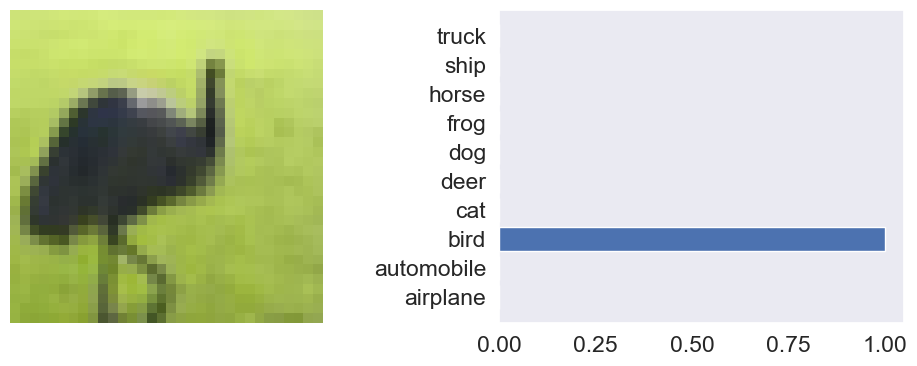

In [7]:
print(f'Label = {text_labels[label.argmax(1)[0]]}')
plot_image_and_probs(image, model)

# Finding an Adversarial Example

Now, let us find an adverarial example by the means of the gradient descent (or rather, ascent) method. This is known as the fast gradient (sign) method (FGSM)
$$
    \mathbf{z}_{j+1} = \mathbf{z}_{j}
    + 
    \epsilon 
    \text{Sign}
    \left(
        \nabla_\mathbf{z}
        L(\hat{y}(\mathbf{z}_j;\theta), y) 
    \right)
$$

In [10]:
loss_func = tf.losses.categorical_crossentropy
perturbed_image = tf.constant(
    image + 0.05*np.random.normal(size=image.shape), dtype='float32')
epsilon = 0.01

for _ in tqdm.tqdm(range(5)):
    with tf.GradientTape() as tape:
        tape.watch(perturbed_image)
        prediction = model(perturbed_image)
        loss = loss_func(label, prediction)
        gradient = tape.gradient(loss, perturbed_image)
        signed_grad = tf.sign(gradient)
        perturbed_image = perturbed_image + epsilon * signed_grad
        perturbed_image = tf.clip_by_value(perturbed_image, 0.0, 1.0)

100%|██████████| 5/5 [00:00<00:00, 62.67it/s]


1/1 [==============================] - 0s 21ms/step


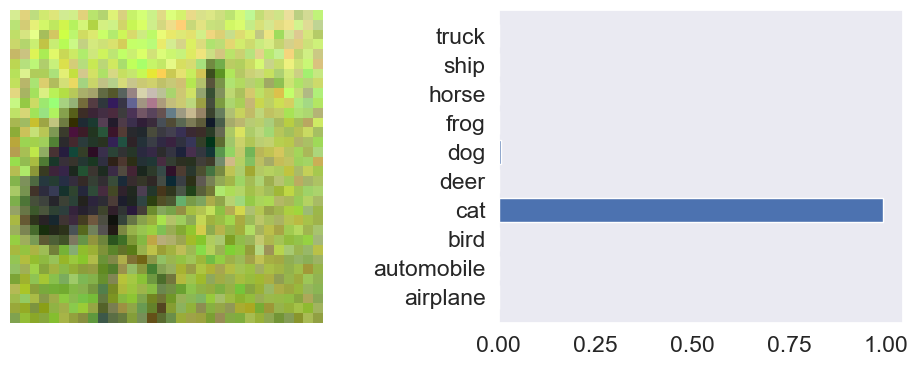

In [11]:
perturbed_image_numpy = perturbed_image.numpy()
plot_image_and_probs(perturbed_image_numpy, model)

We can see that a very small perturbation can induce a large deviation in the prediction! In other words, are models are very *brittle*. How can we make it more robust?

**Remark.** Note that a better way to implement such attacks would be to use some adversarial attack/defense framework, e.g. one introduced below.

# Adversarial Training

One way to improve adversarial robustness is by adversarial training. The basic idea is to introduce adversarial perturbations to the training dataset during model fitting. There are many methods to do this.

Here, we will use the [Adversarial Robustness 360 Toolbox](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/index.html), which is compatible with `Keras`. 

As an alternative, you can also use the [Neural Structured Learning](https://www.tensorflow.org/neural_structured_learning/) API provided by tensorflow.

In [12]:
tf.compat.v1.disable_eager_execution()  # Disable eager execution, as currently required by ART
from art.attacks.evasion import FastGradientMethod
#from art.classifiers import KerasClassifier
from art.estimators.classification import KerasClassifier
from art.defences.trainer import AdversarialTrainer

C:\Users\matyrl\Anaconda3\lib\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [13]:
model_adv = load_model('cifar10_baseline_augment.h5')
model_adv.add(tf.keras.layers.Activation('softmax'))
model_adv.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [14]:
model_wrapped = KerasClassifier(model_adv, clip_values=(0, 1), use_logits=False)
fgm = FastGradientMethod(model_wrapped, eps=0.01)
adv_trainer = AdversarialTrainer(model_wrapped, attacks=fgm, ratio=1.0)

In [15]:
try:
    model_adv = load_model('cifar10_adv.h5')
except:
    history = adv_trainer.fit(
        x=x_train,
        y=y_train,
        nb_epochs=10,
        validation_data=(x_test, y_test),
        batch_size=128,
    )
    model_adv.save('cifar10_adv.h5')

Adversarially Trained Network
Label = bird


C:\Users\matyrl\Anaconda3\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


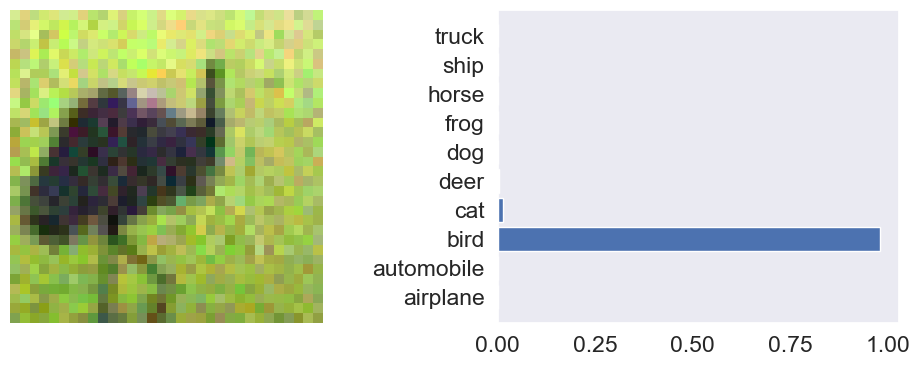

In [16]:
print('Adversarially Trained Network')
print(f'Label = {text_labels[label.argmax(1)[0]]}')
plot_image_and_probs(perturbed_image_numpy, model_adv)

# Exercises

1. Is the trained model robust to any small perturbations? Play around with it. You will find that although more robust than the original model, it is still brittle.
2. Combine adversarial training with the regularization techniques introduced earlier to build an accurate and robust model. You may need to do some parameter tuning.